In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import random

import dask.dataframe as dd

sys.path.append("../")
from src.utils import *
from src.LSN_roi import *
from src.simul import *

import matplotlib.pyplot as plt

/home/nikhil/anaconda3/envs/green_compute/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
summary_results_dir = "/home/nikhil/projects/brain_changes/brain-diff/results/summary/"
results_configs = {
                    "SFCN": "SFCN_model_single_visit_train_two_visit_subset_test_two_visit_subset.csv",
                    "Baseline_single_visit_large": "baseline_model_single_visit_train_full_ses2_test_two_visit_subset.csv",
                    "Baseline_single_visit_small": "baseline_model_single_visit_train_two_visit_subset_test_two_visit_subset.csv",
                    "Baseline_two_visits": "baseline_model_two_visits_train_two_visit_subset_test_two_visit_subset.csv",
                    "LSN": "LSN_model_two_visit_train_two_visit_subset_test_two_visit_subset.csv"
                }

# n_test subjects: SFCN (3 error_type): 8799/3,
# Baseline_single_visit_large (3 error_type): 9603/3, 
# Baseline_single_visit_small(3 error_type): 3171/3, 
# Baseline_two_visits (3 error_type, 2 models, 2 data_aug): 11496/(3*2*2),
# LSN (3 error_type, 2 data_aug): 5748/(3*2)

In [3]:
perf_df = pd.DataFrame()
for config, f in results_configs.items():
    df = pd.read_csv(f"{summary_results_dir}{f}")
    print(f"config: {config}, df shape: {df.shape}")
    df["config"] = config
    perf_df = perf_df.append(df)

perf_df.loc[perf_df["data_aug"].isna(),"data_aug"] = False
perf_df["Benjamin_Button"] = perf_df["brainage_at_ses3"] < perf_df["brainage_at_ses2"]

print(perf_df["visit_order"].unique())

perf_df.head()

config: SFCN, df shape: (8799, 11)
config: Baseline_single_visit_large, df shape: (9603, 11)
config: Baseline_single_visit_small, df shape: (3171, 11)
config: Baseline_two_visits, df shape: (11496, 12)
config: LSN, df shape: (5748, 13)
[nan 'B,F']


,Unnamed: 0,eid,model,age_at_ses2,brainage_at_ses2,age_at_ses3,brainage_at_ses3,chronoage_delta,brainage_delta,err_type,error,config,data_aug,visit_order,Benjamin_Button
0,0,1004084,SFCN,70.0,66.834612,72.0,68.104931,2.0,1.270319,baseline_err,-3.165388,SFCN,False,NaN,False
1,1,1010063,SFCN,53.0,52.458433,55.0,53.228092,2.0,0.769659,baseline_err,-0.541567,SFCN,False,NaN,False
2,2,1014782,SFCN,70.0,61.505157,72.0,66.927790,2.0,5.422634,baseline_err,-8.494843,SFCN,False,NaN,False
3,3,1016215,SFCN,65.0,65.544100,67.0,68.055118,2.0,2.511018,baseline_err,0.544100,SFCN,False,NaN,False
4,4,1022531,SFCN,66.0,65.136880,68.0,68.032131,2.0,2.895252,baseline_err,-0.863120,SFCN,False,NaN,False


err_type      model          
baseline_err  GradBoost_large    5.023770
              GradBoost_small    5.160370
              LSN                5.105686
              RF                 5.055976
              Ridge              4.828592
              SFCN               4.221902
delta_err     GradBoost_large    2.827525
              GradBoost_small    2.587496
              LSN                1.138476
              RF                 1.359421
              Ridge              1.190070
              SFCN               1.436185
followup_err  GradBoost_large    5.077393
              GradBoost_small    5.401824
              LSN                5.111885
              RF                 5.012495
              Ridge              4.784898
              SFCN               4.892052
Name: abs_error, dtype: float64


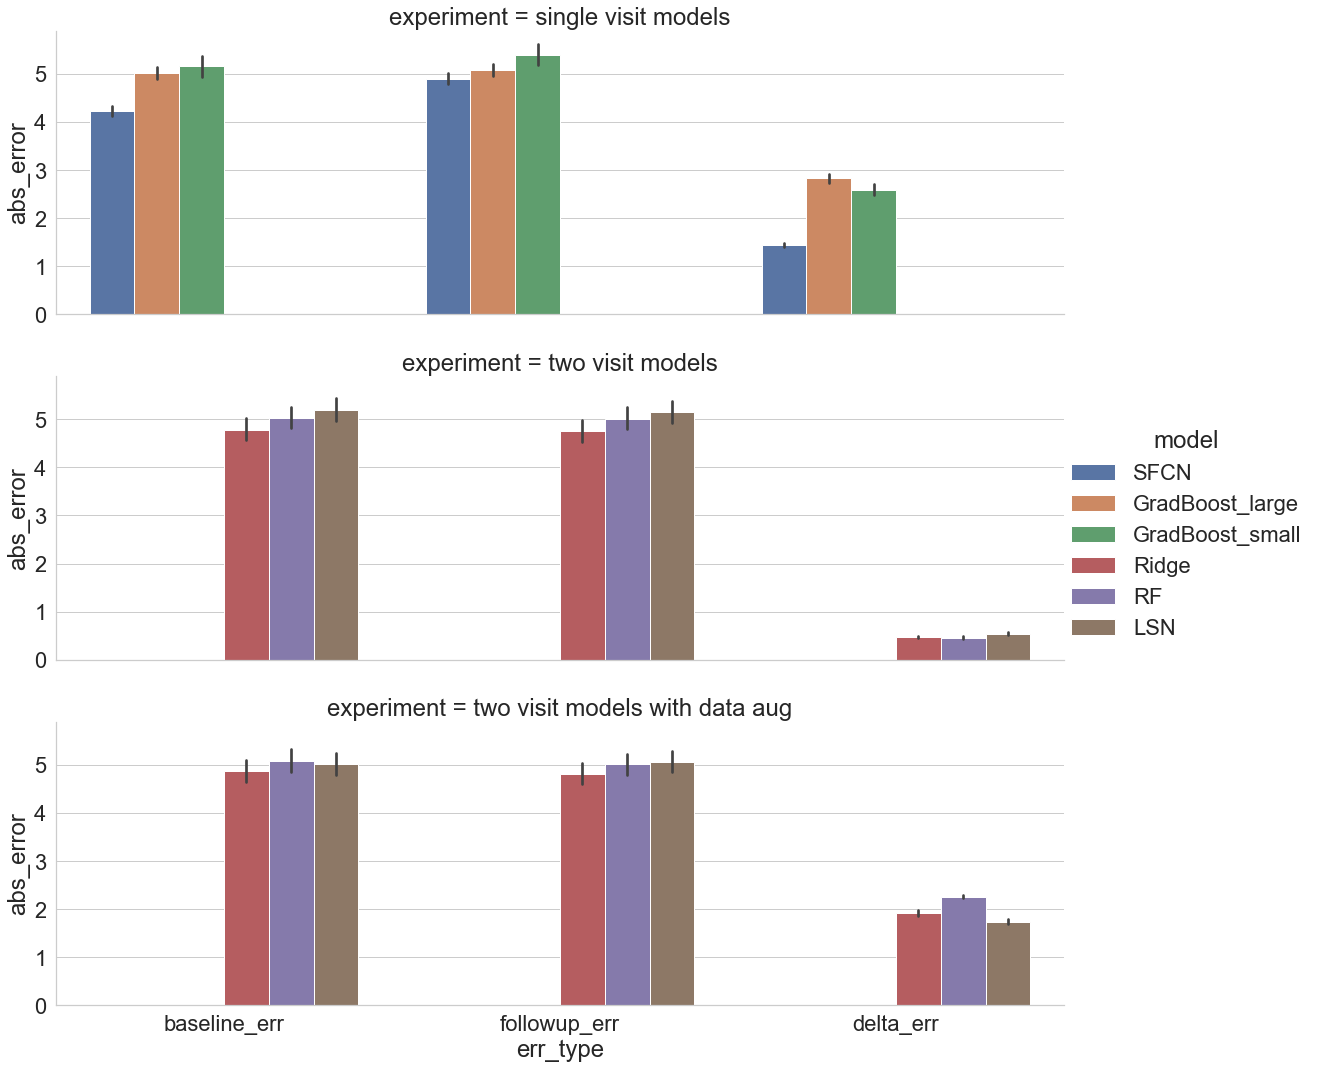

In [6]:
plot_df = perf_df.copy()
plot_df["abs_error"] = np.abs(plot_df["error"]) 
plot_df.loc[plot_df["config"].isin(["SFCN","Baseline_single_visit_large","Baseline_single_visit_small"]), "experiment"] = "single visit models"
plot_df.loc[plot_df["config"].isin(["LSN", "Baseline_two_visits"]), "experiment"] = "two visit models"
plot_df.loc[(plot_df["config"].isin(["LSN", "Baseline_two_visits"])) & (plot_df["data_aug"]), "experiment"] = "two visit models with data aug"

# data aug has large delta-brainage error
plot_df = plot_df[plot_df["experiment"].isin(["single visit models","two visit models"])]
print(plot_df.groupby(["err_type","model"]).mean()["abs_error"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="err_type",y="abs_error", hue="model", col="experiment", col_wrap=1, kind="bar", data=plot_df,aspect=3)

In [5]:
BB_df = perf_df[perf_df["err_type"]=="delta_err"].groupby(["config","model","data_aug"]).sum()["Benjamin_Button"].reset_index()
BB_df["count"] = perf_df[perf_df["err_type"]=="delta_err"].groupby(["config","model","data_aug"]).count()["Benjamin_Button"].values
BB_df["Benjamin Buttons (%)"] = 100*BB_df["Benjamin_Button"] / BB_df["count"]
BB_df

,config,model,data_aug,Benjamin_Button,count,Benjamin Buttons (%)
0,Baseline_single_visit_large,GradBoost_large,False,1328,3201,41.487035
1,Baseline_single_visit_small,GradBoost_small,False,443,1057,41.911069
2,Baseline_two_visits,RF,False,0,958,0.000000
3,Baseline_two_visits,RF,True,423,958,44.154489
4,Baseline_two_visits,Ridge,False,0,958,0.000000
5,Baseline_two_visits,Ridge,True,304,958,31.732777
6,LSN,LSN,False,0,958,0.000000
7,LSN,LSN,True,150,958,15.657620
8,SFCN,SFCN,False,363,2933,12.376406


In [ ]:
plot_df = BB_df[BB_df["data_aug"]==False].copy()
xorder = ["SFCN", "GradBoost_large","GradBoost_small","Ridge","RF","LSN"]
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="model",y="Benjamin Buttons (%)", order=xorder, kind="bar", data=plot_df,aspect=3)

## Null Errors (i.e. model predicts median)

In [ ]:
age_at_ses2 = perf_df[(perf_df["config"]=="SFCN")&(perf_df["err_type"]=="delta_err")]["age_at_ses2"]
age_at_ses3 = perf_df[(perf_df["config"]=="SFCN")&(perf_df["err_type"]=="delta_err")]["age_at_ses3"]

ses2_median = np.median(age_at_ses2)
ses3_median = np.median(age_at_ses3)

ses2_null_err = ses2_median - perf_df[(perf_df["config"]=="SFCN")&(perf_df["err_type"]=="delta_err")]["age_at_ses2"].values
ses3_null_err = ses3_median - perf_df[(perf_df["config"]=="SFCN")&(perf_df["err_type"]=="delta_err")]["age_at_ses3"].values

np.mean(np.abs(ses2_null_err)),np.mean(np.abs(ses3_null_err))